# Prep data

In [1]:
import sys
import time
from os import listdir
import gzip

from collections import Counter, defaultdict
from itertools import chain, product

import numpy as np
from scipy import sparse
import random

In [2]:
chrom = '22'
#chrom = '18'
family_size_param = 'all'
ped_file = '160826.ped'
data_dir = 'split_gen'
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
variant_file = '%s/chr.%s.gen.variants.txt.gz' % (data_dir, chrom)
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%s' % ('X' if chrom.startswith('PAR') else chrom)) in f and 'gen.npz' in f])


In [3]:
g_cost = {
	(-2, -2): 0,
	(-2, -1): 0,
	(-2, 0): 1,
	(-2, 1): 2,
	(-2, 2): 2,
	(0, -2): 100,
	(0, -1): 0,
	(0, 0): 0,
	(0, 1): 1,
	(0, 2): 2,
	(1, -2): 100,
	(1, -1): 0,
	(1, 0): 1,
	(1, 1): 0,
	(1, 2): 1,
	(2, -2): 100,
	(2, -1): 0,
	(2, 0): 2,
	(2, 1): 1,
	(2, 2): 0
}

PAR1X = (60001, 2699520)
PAR2X = (154931044, 155260560)

In [4]:
# pull families with sequence data
with open(sample_file, 'r') as f:
	sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# pull families from ped file
families = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        if child_id in sample_ids and f_id in sample_ids and m_id in sample_ids:
        	if (fam_id, m_id, f_id) not in families:
        		families[(fam_id, m_id, f_id)] = [m_id, f_id]
        	families[(fam_id, m_id, f_id)].append(child_id)

family_to_indices = dict([(fid, [sample_id_to_index[x] for x in vs]) for fid, vs in families.items()])
family_to_index = dict([(fid, i) for i, fid in enumerate(families.keys())])

print('families with sequence data', len(families))
print('family sizes', Counter([len(x) for x in families.values()]))

families with sequence data 886
family sizes Counter({4: 436, 5: 356, 6: 57, 3: 18, 7: 13, 9: 4, 10: 1, 8: 1})


In [5]:
# ancestral_variants (m1, m2, p1, p2)
anc_variants = np.array(list(product(*[[0, 1]]*4)), dtype=np.int8)
anc_variant_to_index = dict([(tuple(x), i) for i, x in enumerate(anc_variants)])
print('ancestral variants', anc_variants.shape)

ancestral variants (16, 4)


In [6]:
# pull genotype data from .npz
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])
m, n = whole_chrom.shape
print('chrom shape', m, n, type(whole_chrom))

chrom shape 4610 1096535 <class 'scipy.sparse.csc.csc_matrix'>


In [10]:
# If we're looking at one of the PAR, restrict X to appropriate region
if chrom == 'PAR1':
	PAR1X_indices = np.where(np.logical_and(snp_positions >= PAR1X[0], snp_positions <= PAR1X[1]))[0]
	whole_chrom = whole_chrom[:, PAR1X_indices]
	snp_positions = snp_positions[PAR1X_indices]
elif chrom == 'PAR2':
	PAR2X_indices = np.where(np.logical_and(snp_positions >= PAR2X[0], snp_positions <= PAR2X[1]))[0]
	whole_chrom = whole_chrom[:, PAR2X_indices]
	snp_positions = snp_positions[PAR2X_indices]

In [54]:
# Change long stretches of missing values to -2 = deleted region
is_neg = (whole_chrom == -1).A
x, y = np.where(is_neg[:, :-4] & is_neg[:, 1:-3] & is_neg[:, 2:-2] & is_neg[:, 3:-1] & is_neg[:, 4:])
whole_chrom[x, y+2] = -2
print('Changed %0.2f of missing to deleted' % (x.shape[0]/np.sum(is_neg)))

In [15]:
family = random.choice(list(family_to_indices.keys()))
m = len(family_to_indices[family])
print(family, m)

('AU1644', 'AU1644202', 'AU1644203') 5


In [16]:
# inheritance states
#
# for parents:
# (0, 0) -> normal
# (0, 1) -> deletion on parental2
# (1, 0) -> deletion on parental1
# (1, 1) -> deletion on parental1 and parental2
# 
# for children:
# (0, 0) -> m1p1
# (0, 1) -> m1p2
# (1, 0) -> m2p1
# (1, 1) -> m2p2

inheritance_states = np.array(list(product(*[[0, 1]]*(2*m))), dtype=np.int8)
state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
p = inheritance_states.shape[0]
print('inheritance states', inheritance_states.shape)

inheritance states (1024, 10)


In [17]:
# genotypes
genotypes = np.array(list(product(*[[-2, -1, 0, 1, 2]]*m)), dtype=np.int8)
genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(genotypes)])
q = genotypes.shape[0]
print('genotypes', genotypes.shape)

genotypes (3125, 5)


In [18]:
# transition matrix
# only allow one shift at a time
shift_costs = [20]*4 + [500]*(2*(m-2))

transitions = [[i] for i in range(p)]
transition_costs = [[0] for i in range(p)]
for i, state in enumerate(inheritance_states):
    for j in range(len(shift_costs)):
        for k in range(state[j]):
            new_state = tuple(k if i == j else x for i, x in enumerate(state))
            if new_state in state_to_index:
                new_index = state_to_index[new_state]
                transitions[i].append(new_index)
                transition_costs[i].append(shift_costs[j])
                transitions[new_index].append(i)
                transition_costs[new_index].append(shift_costs[j])
            
transitions = np.array(transitions)
transition_costs = np.array(transition_costs)
print('transitions', transitions.shape)

transitions (1024, 11)


In [32]:
# loss matrix
losses = np.zeros((p, q), dtype=np.int16)
for i, s in enumerate(inheritance_states):
	state_losses = np.zeros((q, anc_variants.shape[0]), dtype=np.int16)

	# mom
	if s[0] == 0 and s[1] == 0:
		pred_gens = anc_variants[:, 0] + anc_variants[:, 1]
	elif s[0] == 0:
		pred_gens = 2*anc_variants[:, 0]
	elif s[1] == 0:
		pred_gens = 2*anc_variants[:, 1]
	else:
		pred_gens = -2*np.ones((anc_variants.shape[0],))
	for obs_gen in [-2, -1, 0, 1, 2]:
		state_losses[genotypes[:, 0]==obs_gen, :] += [g_cost[(pred_gen, obs_gen)] for pred_gen in pred_gens]
        
	# dad
	if s[2] == 0 and s[3] == 0:
		pred_gens = anc_variants[:, 2] + anc_variants[:, 3]
	elif s[2] == 0:
		pred_gens = 2*anc_variants[:, 2]
	elif s[3] == 0:
		pred_gens = 2*anc_variants[:, 3]
	else:
		pred_gens = -2*np.ones((anc_variants.shape[0],))
	for obs_gen in [-2, -1, 0, 1, 2]:
		state_losses[genotypes[:, 1]==obs_gen, :] += [g_cost[(pred_gen, obs_gen)] for pred_gen in pred_gens]
      
	# children
	for index in range(m-2):
		mat, pat = s[(4+(2*index)):(6+(2*index))]

		if s[mat] == 0 and s[2+pat] == 0:
			pred_gens = anc_variants[:, mat] + anc_variants[:, 2+pat]
		elif s[mat] == 0:
			pred_gens = 2*anc_variants[:, mat]
		elif s[2+pat] == 0:
			pred_gens = 2*anc_variants[:, 2+pat]
		else:
			pred_gens = -2*np.ones((anc_variants.shape[0],))
		for obs_gen in [-2, -1, 0, 1, 2]:
			state_losses[genotypes[:, 2+index]==obs_gen, :] += [g_cost[(pred_gen, obs_gen)] for pred_gen in pred_gens]

	losses[i, :] = np.min(state_losses, axis=1)

print('losses', losses.shape, losses)

losses (1024, 3125) [[500 400 400 ...,   2   1   0]
 [500 400 400 ...,   2   1   0]
 [500 400 400 ...,   2   1   0]
 ..., 
 [  0   0   1 ...,   9  10  10]
 [  0   0   1 ...,   9  10  10]
 [  0   0   1 ...,   9  10  10]]


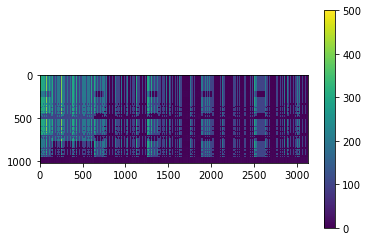

In [33]:
import matplotlib.pyplot as plt

plt.imshow(losses)
plt.colorbar()
plt.show()

In [651]:
from sklearn.utils.extmath import cartesian

# generate all possible inheritance states

# for family:
# (0) -> normal
# (1) -> het
#
# for parents:
# (0, 0) -> normal
# (0, 1) -> deletion on parental2
# (1, 0) -> deletion on parental1
# (1, 1) -> deletion on parental1 and parental2
# 
# for children:
# (0, 0) -> m1p1
# (0, 1) -> m1p2
# (1, 0) -> m2p1
# (1, 1) -> m2p2

cart_list = [[0]] + [[0, 1]]*4 + [[0, 1]]*(2*m-4)
print(cart_list)
inheritance_states = np.array(cartesian(cart_list), dtype=np.int8)

state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
p = inheritance_states.shape[0]
print(inheritance_states.shape)


[[0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
(256, 9)


In [652]:
from collections import defaultdict, Counter

# generate all possible genotypes
cart_list = [[-1, 0, 1, 2]]*m
print(cart_list)
genotypes = np.array(cartesian(cart_list), dtype=np.int8)
genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(genotypes)])
q = genotypes.shape[0]
print(genotypes.shape)


g_neighbors = {0: [1],
               1: [0, 2],
               2: [1],
               -1: [0, 1, 2]}

g_equivalents = {0: [0, -1],
                 1: [1, -1],
                 2: [2, -1],
                -1: [-1]}

g_hsr_equivalents = {0: [0, -1],
                     1: [1, -1, 0, 2],
                     2: [2, -1],
                    -1: [-1]}

# map genotypes to neighbors and equivalents
genotype_to_neighbors = []
genotype_to_equivalents = []
genotype_to_hsr_equivalents = []

for g in genotypes:
    neighbor_gs = []
    for j in range(m):
        for new_entry in g_neighbors[g[j]]:
            new_genotype = tuple(new_entry if k == j else x for k, x in enumerate(g))
            neighbor_gs.append(genotype_to_index[new_genotype])
    genotype_to_neighbors.append(neighbor_gs)   
    
    genotype_to_equivalents.append([genotype_to_index[tuple(x)] for x in cartesian([g_equivalents[x] for x in g])]) 
    genotype_to_het_equivalents.append([genotype_to_index[tuple(x)] for x in cartesian([g_het_equivalents[x] for x in g])])  
    genotype_to_hsr_equivalents.append([genotype_to_index[tuple(x)] for x in cartesian([g_hsr_equivalents[x] for x in g])])  
    
print(Counter([len(x) for x in genotype_to_neighbors]))

[[-1, 0, 1, 2], [-1, 0, 1, 2], [-1, 0, 1, 2], [-1, 0, 1, 2]]
(256, 4)
Counter({6: 56, 7: 56, 8: 49, 5: 32, 9: 28, 4: 16, 10: 14, 11: 4, 12: 1})


In [653]:
import random
g = random.randint(0, genotypes.shape[0])
print(genotypes[g, :])
print(genotypes[genotype_to_equivalents[g], :])
print(genotypes[genotype_to_neighbors[g], :])

[ 2  2 -1  1]
[[ 2  2 -1  1]
 [ 2  2 -1 -1]
 [ 2 -1 -1  1]
 [ 2 -1 -1 -1]
 [-1  2 -1  1]
 [-1  2 -1 -1]
 [-1 -1 -1  1]
 [-1 -1 -1 -1]]
[[ 1  2 -1  1]
 [ 2  1 -1  1]
 [ 2  2  0  1]
 [ 2  2  1  1]
 [ 2  2  2  1]
 [ 2  2 -1  0]
 [ 2  2 -1  2]]


In [654]:
# generate all possible ancestral_variants
anc_variants = np.array(cartesian([[0, 1]]*4))
anc_variant_to_index = dict([(tuple(x), i) for i, x in enumerate(anc_variants)])
print(anc_variants.shape)

(16, 4)


# Prep transition matrix and cost matrix

In [655]:
from collections import defaultdict, Counter

# transition matrix
# only allow one shift at a time
shift_costs = [10] + [10]*4 + [200]*(2*(m-2))

valid_transitions = [[i] for i in range(p)]
transition_costs = [[0] for i in range(p)]
for i, state in enumerate(inheritance_states):
    for j in range(len(shift_costs)):
        for k in range(state[j]):
            new_state = tuple(k if i == j else x for i, x in enumerate(state))
            if new_state in state_to_index:
                new_index = state_to_index[new_state]
                valid_transitions[i].append(new_index)
                transition_costs[i].append(shift_costs[j])
                valid_transitions[new_index].append(i)
                transition_costs[new_index].append(shift_costs[j])
            
restricted_transitions = np.array(valid_transitions)
restricted_transition_cost = np.array(transition_costs)
print(restricted_transitions.shape)

(256, 9)


In [656]:
pos_transition_cost = np.asarray([[inheritance_states[to_state, 0] != 0 and inheritance_states[from_state, 0] != 0 for from_state in x] for to_state, x in enumerate(valid_transitions)], dtype=int)
print(pos_transition_cost)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [657]:
miss_transition_cost = np.asarray([[inheritance_states[to_state, 0] == 0 and inheritance_states[from_state, 0] == 0 for from_state in x] for to_state, x in enumerate(valid_transitions)], dtype=int)
print(miss_transition_cost)

[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


In [658]:
from itertools import chain

# loss matrix
losses = np.zeros((p, q)) - 1

for i, s in enumerate(inheritance_states):
    
    # what genotypes can be validly produced from this inheritance state?          
    valid_genotypes = np.zeros((anc_variants.shape[0], m), dtype=int)
        
    # mom
    if s[1] == 0 and s[2] == 0:
        valid_genotypes[:, 0] = anc_variants[:, 0] + anc_variants[:, 1]
    elif s[1] == 0:
        valid_genotypes[:, 0] = 2*anc_variants[:, 0]
    elif s[2] == 0:
        valid_genotypes[:, 0] = 2*anc_variants[:, 1]
    else:
        valid_genotypes[:, 0] = -1
            
    # dad
    if s[3] == 0 and s[4] == 0:
        valid_genotypes[:, 1] = anc_variants[:, 2] + anc_variants[:, 3]
    elif s[3] == 0:
        valid_genotypes[:, 1] = 2*anc_variants[:, 2]
    elif s[4] == 0:
        valid_genotypes[:, 1] = 2*anc_variants[:, 3]
    else:
        valid_genotypes[:, 1] = -1
        
    # children
    for index in range(m-2):
        mat, pat = s[(5+(2*index)):(7+(2*index))]
        
        if s[1+mat] == 0 and s[3+pat] == 0:
            valid_genotypes[:, 2+index] = anc_variants[:, mat] + anc_variants[:, 2+pat]
        elif s[1+mat] == 0:
            valid_genotypes[:, 2+index] = 2*anc_variants[:, mat]
        elif s[3+pat] == 0:
            valid_genotypes[:, 2+index] = 2*anc_variants[:, 2+pat]
        else:
            valid_genotypes[:, 2+index] = -1

    valid_genotypes = set([genotype_to_index[tuple(x)] for x in valid_genotypes]) 
    
    if s[0] == 0:
        equimap = genotype_to_equivalents
    elif s[0] == 1:
        # in a hard to sequence region, -1s are ok
        equimap = genotype_to_hsr_equivalents

    # breadth first search to fill in loss for this state
    current_cost = 0
    while len(valid_genotypes) > 0:
        # add equivalents
        valid_genotypes = valid_genotypes | set(chain.from_iterable([equimap[x] for x in valid_genotypes]))

        next_gen = set()
        for g in valid_genotypes:
            # fill in loss matrix
            if losses[i, g] == -1:
                losses[i, g] = current_cost

                # pull next generation
                next_gen.update([ng for ng in genotype_to_neighbors[g] if losses[i, ng] == -1])

        valid_genotypes = next_gen
        current_cost += 1  
        
losses[inheritance_states[:, 0] == 1, 1:] += 2
    
                
# Check if we've missed some
print(np.sum(losses == -1)/(losses.shape[0]*losses.shape[1]))

0.0


//anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


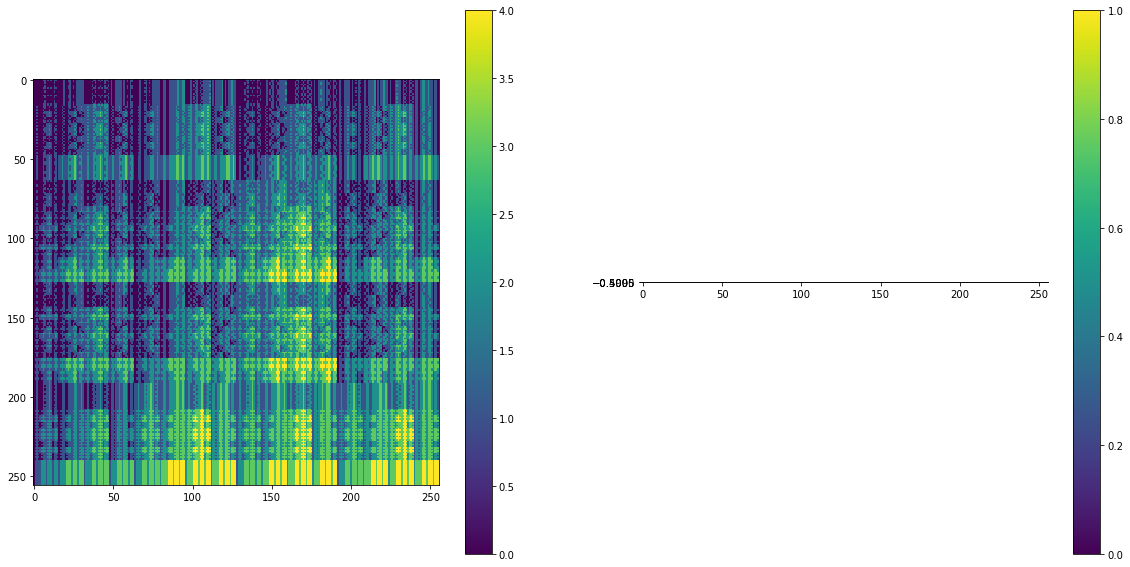

In [659]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(losses[inheritance_states[:, 0] == 0, :])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(losses[inheritance_states[:, 0] == 1, :])
plt.colorbar()

plt.show()

# Viterbi

In [660]:
v_cost = np.zeros((p, n+2), dtype=int)
v_traceback = np.zeros((p, n+2), dtype=int)

In [661]:
import time

# forward sweep
prev_time = time.time()
pos_to_genindex = [genotype_to_index[tuple(x)] for x in family_genotypes.T]

v_traceback[:, 0] = -1
for j in range(n): 
    
    total_cost = v_cost[restricted_transitions, j] + restricted_transition_cost #\
    #    + (normal_to_normal_cost[j]*pos_transition_cost) \
    #    + (missing_to_missing_cost[j]*miss_transition_cost)
    min_index = np.argmin(total_cost, axis=1)
    v_traceback[:, j+1] = restricted_transitions[range(p), min_index]
    v_cost[:, j+1] = total_cost[range(p), min_index] + losses[:, pos_to_genindex[j]]

    if j % 100000 == 0:
        print(j)

# last step
total_cost = v_cost[restricted_transitions, n] + restricted_transition_cost #\
   #     + (normal_to_normal_cost[n]*pos_transition_cost) \
   #     + (missing_to_missing_cost[n]*miss_transition_cost)
min_index = np.argmin(total_cost, axis=1)
v_traceback[:, n+1] = restricted_transitions[range(p), min_index]
v_cost[:, n+1] = total_cost[range(p), min_index]
    
print('Forward sweep complete', time.time()-prev_time, 'sec') 

0
Forward sweep complete 11.004208087921143 sec


In [662]:
print(v_cost[:, n+1])

[6483 6682 6298 6485 6682 6483 6485 6298 6298 6485 6483 6682 6485 6298 6682
 6483 6493 6691 6308 6494 6692 6492 6495 6307 6308 6494 6493 6691 6495 6307
 6692 6492 6492 6692 6307 6495 6691 6493 6494 6308 6307 6495 6492 6692 6494
 6308 6691 6493 6502 6701 6317 6504 6701 6502 6504 6317 6317 6504 6502 6701
 6504 6317 6701 6502 6493 6692 6308 6495 6692 6493 6495 6308 6307 6494 6493
 6692 6494 6307 6692 6493 6503 6701 6318 6504 6702 6502 6505 6317 6317 6503
 6503 6701 6504 6317 6702 6502 6502 6702 6317 6505 6701 6503 6504 6318 6317
 6504 6502 6702 6503 6317 6701 6503 6513 6712 6328 6515 6712 6513 6515 6328
 6327 6513 6513 6712 6513 6327 6712 6513 6493 6692 6307 6494 6692 6493 6494
 6307 6308 6495 6493 6692 6495 6308 6692 6493 6503 6701 6317 6503 6702 6502
 6504 6317 6318 6504 6503 6701 6505 6317 6702 6502 6502 6702 6317 6504 6701
 6503 6503 6317 6317 6505 6502 6702 6504 6318 6701 6503 6513 6712 6327 6513
 6712 6513 6513 6327 6328 6515 6513 6712 6515 6328 6712 6513 6504 6703 6317
 6504 6703 6

In [663]:
# Backward sweep
prev_time = time.time()
index = n+1
k = np.argmin(v_cost[:, index])
print(list(zip(*np.unique(v_cost[:, index], return_counts=True))))

final_states = np.zeros((n+2,), dtype=int)
while index >= 0:
    final_states[index] = k    
    k = v_traceback[k, index]
    index -= 1
    
print('Backward sweep complete', time.time()-prev_time, 'sec') 
print(final_states)

[(6298, 4), (6307, 8), (6308, 8), (6317, 20), (6318, 4), (6327, 12), (6328, 4), (6337, 4), (6483, 4), (6485, 4), (6492, 4), (6493, 12), (6494, 8), (6495, 8), (6502, 12), (6503, 12), (6504, 20), (6505, 4), (6513, 20), (6514, 8), (6515, 4), (6524, 8), (6682, 4), (6691, 4), (6692, 12), (6701, 12), (6702, 8), (6703, 4), (6712, 12), (6713, 4), (6723, 4)]
Backward sweep complete 0.07342100143432617 sec
[0 0 0 ..., 2 2 2]


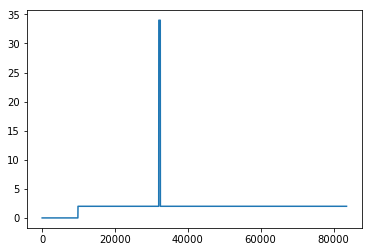

In [664]:
plt.plot(final_states)
plt.show()

In [665]:
final_loss = np.zeros((n+2,), dtype=int)
final_loss[1:-1] = losses[final_states[1:-1], pos_to_genindex]

for i in range(1, n+2):
    from_state = final_states[i-1]
    to_state = final_states[i]
    
    #if inheritance_states[from_state][0] == 0 and inheritance_states[to_state][0] == 0:
    #    final_loss[i] += normal_to_normal_cost[i-1]
    #elif inheritance_states[from_state][0] == 1 and inheritance_states[to_state][0] == 1:
    #    final_loss[i] += missing_to_missing_cost[i-1]
        
print(final_loss)

[0 0 1 ..., 0 1 0]


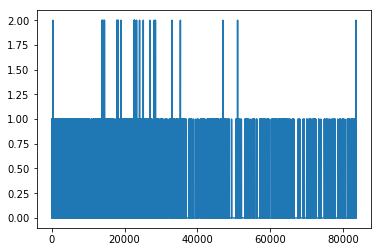

In [666]:
plt.plot(final_loss)
plt.show()

In [667]:
print(v_cost[final_states[1], 1])
print(inheritance_states[final_states[0]], inheritance_states[final_states[-1]])

0
[0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 1 0]


[ 9809  9810 31999 32000 32430]
[ 9809  9810 31999 32000 32430] [ 0  2  2 34 34]


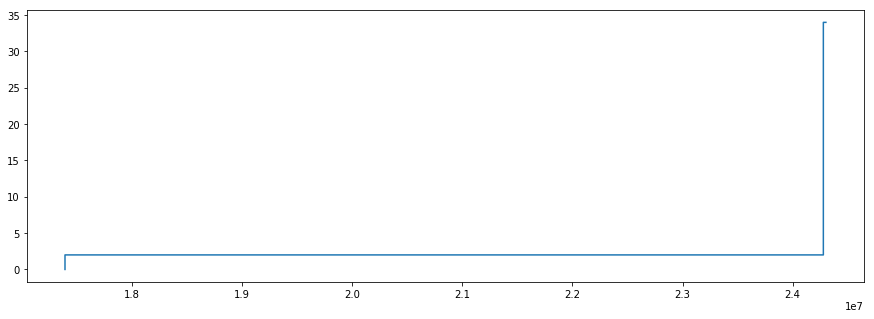

In [668]:
xs = np.where(final_states[1:]-final_states[:-1] != 0)[0]
xs = np.concatenate((xs, xs[:-1]+1))
xs = np.sort(xs)
print(xs)
ys = final_states[xs]
pos = [sum([len(x) for x in refseq]) if x==n else family_snp_positions[x] for x in xs]

print(xs, ys)

plt.figure(figsize=(15, 5))
plt.plot(pos, ys)
plt.show()

In [669]:
print('\n'.join(['%d\t%s'  % (x, str(tuple(inheritance_states[y, :]))) for x, y in zip(xs[:20], ys[:20])]))

9809	(0, 0, 0, 0, 0, 0, 0, 0, 0)
9810	(0, 0, 0, 0, 0, 0, 0, 1, 0)
31999	(0, 0, 0, 0, 0, 0, 0, 1, 0)
32000	(0, 0, 0, 1, 0, 0, 0, 1, 0)
32430	(0, 0, 0, 1, 0, 0, 0, 1, 0)


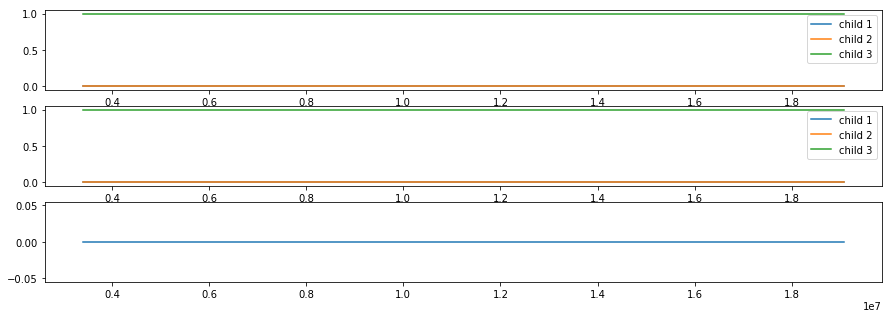

In [631]:
# Children
plt.figure(figsize=(15, 5))
for i in range(m-2):
    plt.subplot(3, 1, 1)
    plt.plot(pos, [inheritance_states[y, 5 + (i*2)] for y in ys], label='child %d' % (i+1))
    
    plt.subplot(3, 1, 2)
    plt.plot(pos, [inheritance_states[y, 6 + (i*2)] for y in ys], label='child %d' % (i+1))

plt.subplot(3, 1, 3)
plt.plot(pos, [inheritance_states[y, 0] for y in ys])

plt.subplot(3, 1, 1)
plt.legend()
plt.subplot(3, 1, 2)
plt.legend()
plt.show()
    

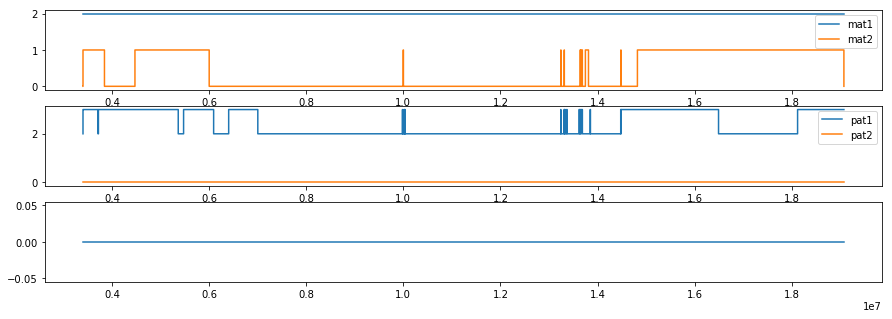

In [632]:
# Parents
plt.figure(figsize=(15, 5))

plt.subplot(3, 1, 1)
plt.plot(pos, [inheritance_states[y, 1]+2 for y in ys], label='mat1')
plt.plot(pos, [inheritance_states[y, 2] for y in ys], label='mat2')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pos, [inheritance_states[y, 3]+2 for y in ys], label='pat1')
plt.plot(pos, [inheritance_states[y, 4] for y in ys], label='pat2')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(pos, [inheritance_states[y, 0] for y in ys])

plt.show()

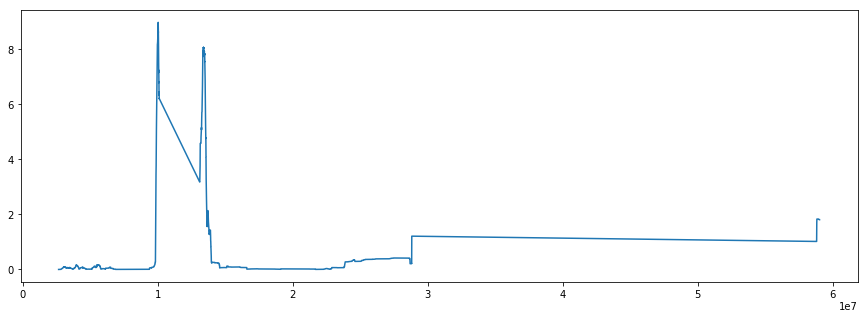

In [633]:
c = 100000

plt.figure(figsize=(15, 5))
plt.plot(family_snp_positions, 1000*sparse_convolve(family_snp_positions, final_loss[1:-1], c)/(c*m))
#plt.ylabel('Errors per person per kilobase (smoothed)')
#plt.plot(family_snp_positions, np.convolve(complex_model_final_loss, np.ones((c,))/(m*c), mode='same'))

#plt.plot(family_snp_positions, 100*sparse_convolve(family_snp_positions, np.sum(family_genotypes == -1, axis=0), c)/(c*m))
#plt.plot(family_snp_positions, np.convolve(np.sum(family_genotypes == -1, axis=0), np.ones((c,))/(m*c), mode='same'))
#plt.plot(np.convolve(simple_model_final_loss, np.ones((c,))/(m*c), mode='same'))
plt.show()

In [53]:
def sparse_convolve(pos, vs, c):
    new_signal = np.zeros(pos.shape)
   
    current_index = 0
    start_index = 0
    running_sum = 0
            
    for end_position, v in zip(pos, vs):
        if end_position - pos[current_index] > c:
            new_signal[current_index] = running_sum
            current_index += 1
            
            # clean up end
            while pos[current_index] - pos[start_index] > c:
                running_sum -= vs[start_index]
                start_index += 1
            
        running_sum += v
        
    for current_index in range(current_index, pos.shape[0]):
        new_signal[current_index] = running_sum        
            
        # clean up end
        while pos[current_index] - pos[start_index] > c:
            running_sum -= vs[start_index]
            start_index += 1
            
    return new_signal
        

(59218,)
[[0 0 0 1 0 0 0 0 0 1 1]]
[[0 0 1 1 0 0 0 0 0 1 1]]
[[0 0 0 1 0 0 0 0 0 1 1]
 [0 0 1 1 0 0 0 0 0 1 1]]


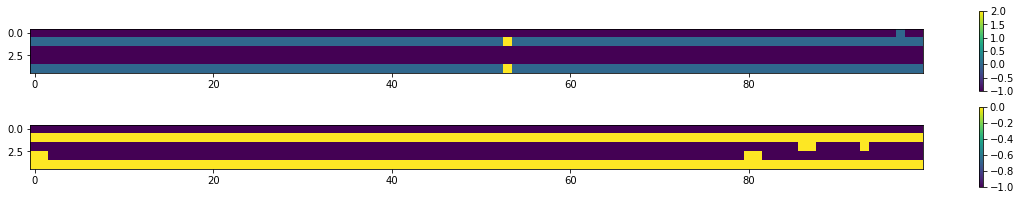

In [634]:
# take a look at deletions
deletion_indices = np.where(np.any(inheritance_states[final_states, 1:5] == 1, axis=1))[0]
print(deletion_indices.shape)

plt.figure(figsize=(20, 5))

plt.subplot(3, 1, 1)
plt.imshow(family_genotypes[:, 30000:30100])
plt.colorbar()
print(inheritance_states[np.unique(final_states[30000:30100]), :])


plt.subplot(3, 1, 2)
plt.imshow(family_genotypes[:, (deletion_indices[100]-100):deletion_indices[100]])
plt.colorbar()

print(inheritance_states[np.unique(final_states[deletion_indices[100:200]]), :])

print(inheritance_states[np.unique(final_states[(deletion_indices[100]-100):(deletion_indices[100])]), :])

plt.show()

3035200 - 3050544
[[0 0 0 0 0 0 0 1 0 0 0]]


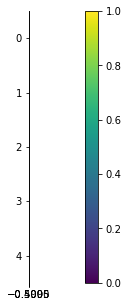

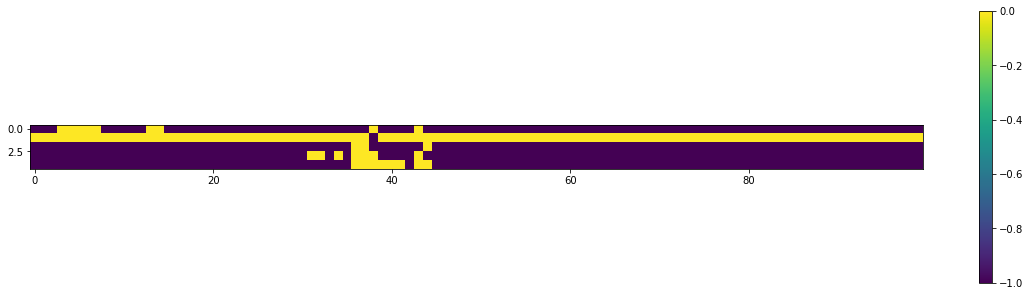

In [534]:
# take a look at bad regions
bad_regions = np.where(1000*sparse_convolve(family_snp_positions, final_loss, c)/(c*m) >= .1)[0]

# take a look at deletions
deletion_indices = np.where(np.any(inheritance_states[final_states, 1:5] == 1, axis=1))[0]

plt.figure(figsize=(20, 5))

start, end = 0, 100
plt.subplot(1, 1, 1)
plt.imshow(family_genotypes[:, bad_regions[start:end]])
plt.colorbar()

#plt.subplot(3, 1, 2)
#plt.imshow(family_genotypes[:, (bad_regions[0]-100):bad_regions[0]])
#plt.colorbar()

print(family_snp_positions[bad_regions[start]], '-', family_snp_positions[bad_regions[end]])
print(inheritance_states[np.unique(final_states[bad_regions[start:end]]), :])

#print(inheritance_states[np.unique(final_states[(bad_regions[0]-100):(bad_regions[0])]), :])

plt.show()


In [137]:
plt.figure(figsize=(10, 5))
bad_region_loss = losses[:, np.array(pos_to_genindex)[bad_regions[200:300]]]
total_state_cost = np.sum(bad_region_loss, axis=1)

best_indices = total_state_cost.argsort()[:5]
for i in best_indices:
    plt.plot(np.convolve(bad_region_loss[i, :], np.ones((10,))/10, mode='same'), label=str(tuple(inheritance_states[i, :])))

interest_index = state_to_index[(1,) + (0,)*(2*m)]
plt.plot(np.convolve(bad_region_loss[interest_index, :], np.ones((10,))/10, mode='same'), label=str(tuple(inheritance_states[interest_index, :])))
plt.legend()
plt.show()

ValueError: v cannot be empty

In [676]:
from itertools import product
family_size=5
print(list(product(range(family_size-2), ['m', 'p'])))

[(0, 'm'), (0, 'p'), (1, 'm'), (1, 'p'), (2, 'm'), (2, 'p')]
